In [1]:
import os
import sys
import scipy.io
import cv2
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np

import tensorflow as tf
import pprint
import time
%matplotlib inline

In [2]:
from tensorflow.python.keras.preprocessing import image as kp_image

In [3]:
tf.executing_eagerly()

True

In [4]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [5]:
content_layers = ['block5_conv2'] 


style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [6]:
def get_model():
    base_model=tf.keras.applications.VGG16(weights='imagenet',include_top=False)
    base_model.trainable=False
    style_outputs=[base_model.get_layer(name).output for name in style_layers]
    content_outputs=[base_model.get_layer(name).output for name in content_layers]
    model_outputs=style_outputs+content_outputs
    return tf.keras.Model(base_model.input,model_outputs)

In [7]:
def get_content_loss(base_content,target):
    return tf.reduce_mean(tf.square(base_content - target))

In [8]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [9]:
def get_style_loss(base_style,gram_target):
    
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
  
    return tf.reduce_mean(tf.square(gram_style - gram_target))
    
    
    
    

In [10]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

    img = kp_image.img_to_array(img)

    # We need to broadcast the image array such that it has a batch dimension
    img = np.expand_dims(img, axis=0)
   

    return img

In [11]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [12]:
def feature_rep(model,content_path,style_path):
    
    content_image=load_and_process_img(content_path)
    style_image=load_and_process_img(style_path)
    
    style_outputs=model(style_image)
    content_outputs=model(content_image)
    
    style_features=[style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    
    content_features=[content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    
    return style_features,content_features

In [13]:
def compute_loss(model,loss_weights,init_image,gram_style_features,content_features):
    style_weight,content_weight=loss_weights
    model_outputs=model(init_image)
    
    style_output_features=model_outputs[:num_style_layers]
    content_output_features=model_outputs[num_style_layers:]
    
    
    style_score=0
    content_score=0
    
    weight_per_style_layer=1.0/float(num_style_layers)
    for target_style,comb_style in zip(gram_style_features,style_output_features):
        style_score+=weight_per_style_layer*get_style_loss(comb_style[0],target_style)
        
    weight_per_content_layer=1.0/float(num_content_layers)
    for target_content,comb_content in zip(content_features,content_output_features):
        content_score+=weight_per_content_layer*get_content_loss(comb_content[0],target_content)
        
    style_score*=style_weight
    content_score*=content_weight
    
    loss=style_score + content_score 
    return loss,style_score,content_score

In [14]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**cfg)
        
        total_loss=all_loss[0]
        return tape.gradient(total_loss,cfg['init_image']),all_loss

In [15]:
import IPython.display
def run_style_transfer(content_path,style_path,num_iterations=1000,content_weight=1e3,style_weight=1e-2):
    
    display_num=100
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable=False
        
    style_features,content_features=feature_rep(model,content_path,style_path)
    gram_style_features=[gram_matrix(style_feature) for style_feature in style_features]
    
    init_image=load_and_process_img(content_path)
    init_image=tf.Variable(init_image,dtype=tf.float32)
    
    opt=tf.compat.v1.train.AdamOptimizer(learning_rate=5.0,beta1=0.99,epsilon=1e-1)
    
    iter_count=1
    
    best_loss,best_img=float('inf'),None
    
    loss_weights=(style_weight,content_weight)
    cfg={
        'model':model,
        'loss_weights':loss_weights,
        'init_image':init_image,
        'gram_style_features':gram_style_features,
        'content_features':content_features
    }
    
    num_rows=2
    num_cols=5
    display_intervals=num_iterations/(num_rows*num_cols)
    start_time=time.time()
    global_start=time.time()
    
    norm_means=np.array([103.939,116.779,123.68])
    min_vals=-norm_means
    max_vals=255-norm_means
    imgs=[]
    for i in range(num_iterations):
        grads,all_loss=compute_grads(cfg)
        loss,style_score,content_score=all_loss
        
        opt.apply_gradients([(grads,init_image)])
        clipped=tf.clip_by_value(init_image,min_vals,max_vals)
        init_image.assign(clipped)
        end_time=time.time()
        
        
        if loss<best_loss:
            best_loss=loss
            best_img=deprocess_img(init_image.numpy())
            
        if i%display_num == 0:
            start_time=time.time()
            plot_img=init_image.numpy()
            plot_img=deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
            
                
        

    
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss 

In [16]:
tf.device('/gpu:1')

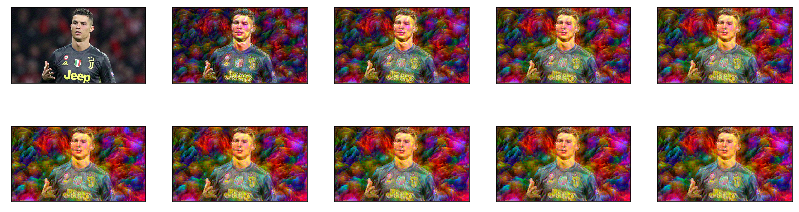

In [17]:
est, best_loss = run_style_transfer('C:/Users/BEVAN/Desktop/cr7.jpg', 
                                     'C:/Users/BEVAN/Desktop/style2.jpg'
                                     )

In [18]:
result=Image.fromarray(est)

In [19]:
result.save("generated3.jpg")